# Amines for Carbon Capture

We now increase the the complexity of the problem by considering amine groups which can be used for carbon dioxide adsorption. Amines are well-known for their reversible reactions with $CO_2$, which make them ideal for the separation of $CO_2$ from many CO2-containing gases, including flue gas. We consider a simple amine group of the form $R-NH_2$  where $R$ is $CH_3$ and obtain the PES for the system $CH_3NH_2 + CO_2$. The reaction occurs by nucleophilic attack of $CO_2$ by $R-NH_2$.

![molecule](../images/co2-ch3nh2/ch3nh2-co2.png)

We consider $CO_2$ in a fixed orientation and calculate PES only versus the distance of $CH_3NH_2$ and $CO_2$. The carbon atom of $CO_2$ line in the axis made by the nitrogen atom and the centroid of $C$ and $H$ (of $CH_3$) and $H$ (bonded with nitrogen). The $C-O$ bonds of $CO_2$ are kept parallel to the $H$ atoms axis bonded with nitrogen. This is depicted in the diagram below.

![molecule](../images/co2-ch3nh2/ch3nh2-co2-centroid.png)

In [2]:
import sys
sys.path.append('..')

In [178]:
import numpy as np
import py3Dmol
from dmet.ccsd_solver import CCSDSolver
from pyscf import gto
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from utils import construct_problem, get_ansatz, init_point_finder, custom_vqe, get_optimizer, rel_err
from utils import device_mapping, seed, deparameterise

from qiskit.providers.fake_provider import FakeNairobi
from qiskit.primitives import Estimator, BackendEstimator

## Construction of the molecule

The optimal structure of $CH_3NH_2$ was obtained from [nist chemistry webook](https://webbook.nist.gov/cgi/cbook.cgi?Name=ch3nh2&Units=SI). We construct the system as described above for varying distance between the amine and $CO_2$.

In [4]:
co2 =  [["C", np.array([17.0000, 10.0000, 0.0000 ])],
        ["O", np.array([18.0221, 10.5679, 0.0000 ])],
        ["O", np.array([15.9779, 9.4321, 0.0000  ])]] 

# Normalize CO2
d_co1 = np.linalg.norm(co2[0][1] - co2[1][1])
d_co2 = np.linalg.norm(co2[0][1] - co2[2][1])

In [5]:
symbols = []
coordinates = []

file = 'ch3nh2.sdf'
with open(file, encoding ='utf-8') as f:
    for line in f.readlines()[4:11]:
        x, y, z, symbol = line.split()[:4]
        symbols.append(symbol)
        coordinates.append(float(x))
        coordinates.append(float(y))
        coordinates.append(float(z))

In [6]:
symbols

['C', 'N', 'H', 'H', 'H', 'H', 'H']

In [99]:
n = np.array(coordinates[3*1:3*(1+1)])
nh1 = np.array(coordinates[3*5:3*(5+1)])
nh2 = np.array(coordinates[3*6:3*(6+1)])
c = np.array(coordinates[3*0:3*(0+1)])
centroid = (nh1 + nh2 + c)/3
vec_a = centroid
vec_b = n

dists = [vec_a + t*(vec_b-vec_a)  for t in np.arange(2, 15, 0.5)]
atomic_distance = [ np.linalg.norm(dist - n)  for dist in dists]
nh12 = nh2 - nh1

In [108]:
geometry = "\n"
for index, symbol in enumerate(symbols):
    geometry += f"{symbol} {coordinates[3*index]} {coordinates[3*index+1]} {coordinates[3*index+2]}\n"

idx = 20
co2_c_coords = dists[idx]
co2_o1_coords = co2_c_coords + nh12*d_co1
co2_o2_coords = co2_c_coords - nh12*d_co2

geometry += f"C {co2_c_coords[0]} {co2_c_coords[1]} {co2_c_coords[2]}\n"
geometry += f"O {co2_o1_coords[0]} {co2_o1_coords[1]} {co2_o1_coords[2]}\n"
geometry += f"O {co2_o2_coords[0]} {co2_o2_coords[1]} {co2_o2_coords[2]}\n"

In [109]:
print(geometry)


C 0.6147 1.0867 0.8571
N 1.9021 1.7634 1.0319
H 0.0879 1.5325 0.0061
H 0.6641 -0.0036 0.6869
H -0.0036 1.257 1.7453
H 2.4036 1.3486 1.8155
H 2.4869 1.6039 0.2133
C 2.639466666666668 6.3504000000000005 1.8011666666666675
O 2.7368670887402393 6.648915339200273 -0.07224217182403403
O 2.542066244593097 6.051884660799728 3.674575505157371



## Reference PES

For finding the reference PES, we use CCSD solver from PySCF. For our analysis, we use the minimal basis set STO-3G. From the reference PES plots and the numbers obtained, the minimum distance for a stable configuration is `1.7124 angstorm` with the corresponding CCSD energy to be `279.0299 Ha`

In [114]:
energies = []

for i, dist in enumerate(dists):
    geometry = ""
    for index, symbol in enumerate(symbols):
        geometry += f"{symbol} {coordinates[3*index]} {coordinates[3*index+1]} {coordinates[3*index+2]};"
    
    co2_c_coords = dist
    co2_o1_coords = co2_c_coords + nh12*d_co1
    co2_o2_coords = co2_c_coords - nh12*d_co2

    geometry += f"C {co2_c_coords[0]} {co2_c_coords[1]} {co2_c_coords[2]};"
    geometry += f"O {co2_o1_coords[0]} {co2_o1_coords[1]} {co2_o1_coords[2]};"
    geometry += f"O {co2_o2_coords[0]} {co2_o2_coords[1]} {co2_o2_coords[2]}"
    
    
    mol = gto.Mole() # Instantiate the molecule class in PySCF
    mol.atom = geometry  # The coordinates of the atoms 
    mol.basis = "sto-3g" # Use "minao" as the basis set
    mol.charge = 0 # Assign the charge of the molecule
    mol.build() # Build the molecule object
    
    ccsd_solver = CCSDSolver()
    ccsd_energy = ccsd_solver.simulate(mol)
    
    energies.append(ccsd_energy)
    
    print(f"{atomic_distance[i]:.4f} {ccsd_energy:.4f}")
    print()

    
    pd.DataFrame({
        'atomic_distance': atomic_distance[:(i+1)],
        'energy': energies
    }).to_csv('ref_pes.csv')

Number of orbitals:  30
Frozen orbitals:  0
0.4281 -268.7430

Number of orbitals:  30
Frozen orbitals:  0
0.6422 -275.6880

Number of orbitals:  30
Frozen orbitals:  0
0.8562 -277.9307

Number of orbitals:  30
Frozen orbitals:  0
1.0703 -278.5459

Number of orbitals:  30
Frozen orbitals:  0
1.2843 -278.7790

Number of orbitals:  30
Frozen orbitals:  0
1.4984 -279.0141

Number of orbitals:  30
Frozen orbitals:  0
1.7124 -279.0299

Number of orbitals:  30
Frozen orbitals:  0
1.9265 -279.0246

Number of orbitals:  30
Frozen orbitals:  0
2.1405 -279.0151

Number of orbitals:  30
Frozen orbitals:  0
2.3546 -279.0083

Number of orbitals:  30
Frozen orbitals:  0
2.5686 -279.0044

Number of orbitals:  30
Frozen orbitals:  0
2.7827 -279.0019

Number of orbitals:  30
Frozen orbitals:  0
2.9967 -279.0004

Number of orbitals:  30
Frozen orbitals:  0
3.2108 -278.9993

Number of orbitals:  30
Frozen orbitals:  0
3.4248 -278.9986

Number of orbitals:  30
Frozen orbitals:  0
3.6389 -278.9982

Number o

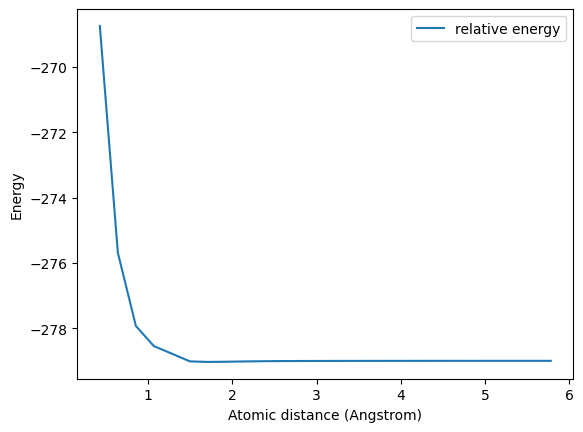

In [118]:
plt.plot(atomic_distance, energies, label="relative energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

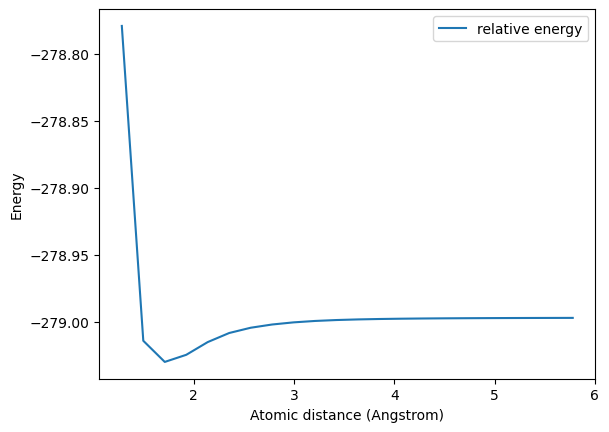

In [122]:
plt.plot(atomic_distance[4:], energies[4:], label="relative energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [128]:
energies

[-268.74295231833963,
 -275.6879908415495,
 -277.93070230340453,
 -278.54586934079543,
 -278.77902624543236,
 -279.0140949752101,
 -279.02988842668094,
 -279.0245839109333,
 -279.01508075407696,
 -279.00830451831,
 -279.0043720100212,
 -279.0019497362116,
 -279.0003552382629,
 -278.9993006316324,
 -278.9986092011572,
 -278.9981520370877,
 -278.99784111409315,
 -278.99762187536567,
 -278.9974618644559,
 -278.9973417586817,
 -278.99724976784205,
 -278.99717780327387,
 -278.9971215384248,
 -278.99707678856157,
 -278.99704087114975,
 -278.997011820198]

In [169]:
min_energy_idx = energies.index(min(energies))
min_dist = atomic_distance[min_energy_idx]
print(f"Minimum distance: {min_dist:.12f} Angstorm")
print(f"Minimum energy: {min(energies):.12f} ")

Minimum distance: 1.712416486204 Angstorm
Minimum energy: -279.029888426681 


## Setup CO2 @ CH3NH2 system

We consider all the electrons in system and keep the number of spatial orbitals to 4 so as to efficiently calculate the ground state energy. We use parity mapping as a mapper to map fermionic hamiltonian to qubit hamiltonian. We also apply two qubit reduction and symmetry reduction to reduce circuit's complexity. The optimal geometry is saved in a pickle file.

In [194]:
charge = 0
S = 0
basis = "sto3g"
mapper_type = 'ParityMapper'
ev = 27.2114
num_spatial_orbitals = 4
num_electrons = None
z2symmetry_reduction = 'auto'
actual_energy = -279.029888426681 * ev

geometry = ""
for index, symbol in enumerate(symbols):
    geometry += f"{symbol} {coordinates[3*index]} {coordinates[3*index+1]} {coordinates[3*index+2]};"

co2_c_coords = dists[min_energy_idx]
co2_o1_coords = co2_c_coords + nh12*d_co1
co2_o2_coords = co2_c_coords - nh12*d_co2

geometry += f"C {co2_c_coords[0]} {co2_c_coords[1]} {co2_c_coords[2]};"
geometry += f"O {co2_o1_coords[0]} {co2_o1_coords[1]} {co2_o1_coords[2]};"
geometry += f"O {co2_o2_coords[0]} {co2_o2_coords[1]} {co2_o2_coords[2]}"

In [181]:
geometry.split(';')

['C 0.6147 1.0867 0.8571',
 'N 1.9021 1.7634 1.0319',
 'H 0.0879 1.5325 0.0061',
 'H 0.6641 -0.0036 0.6869',
 'H -0.0036 1.257 1.7453',
 'H 2.4036 1.3486 1.8155',
 'H 2.4869 1.6039 0.2133',
 'C 2.170233333333334 3.4314 1.3116333333333337',
 'O 2.267633755406905 3.7299153392002724 -0.5617755051573678',
 'O 2.0728329112597628 3.1328846607997276 3.185042171824037']

In [182]:
with open('ch3nh2-co2-geometry-min-energy.pickle', 'wb') as handle:
    pickle.dump(geometry, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [188]:
problem_reduced, converter, qubit_op, res_actual = construct_problem( geometry, 
                                                                      charge, 
                                                                      S, 
                                                                      basis, 
                                                                      mapper_type,
                                                                      num_spatial_orbitals,
                                                                      num_electrons, 
                                                                      z2symmetry_reduction=z2symmetry_reduction)

In [189]:
print(res_actual)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -432.69017501048
  - computed part:      -155.628847646236
  - ActiveSpaceTransformer extracted energy part: -277.061327364244
~ Nuclear repulsion energy (Hartree): 154.047087551131
> Total ground state energy (Hartree): -278.643087459349
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 8.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [133.01202675  189.14873493  86.33957092]
 
  0: 
  * Electronic dipole moment (a.u.): [133.35924758  191.40117082  86.7165939]
    - computed part:      [25.91694287  36.70898303  17.05383514]
    - ActiveSpaceTransformer extracted energy part: [107.44230471  154.69218778  69.66275875]
  > Dipole moment (a.u.): [-0.34722083  -2.25243589  -0.37702298]  Total: 2.31001646
                 (debye): [-0.88254724  -5.72512042  -0.95829673]  Total: 5.87147563
 


In [197]:
exact_energy = res_actual.eigenvalues[0]
total_energy = res_actual.total_energies[0]
print(f'Expected ground state energy: {exact_energy:.12f} Ha')
print(f"Total energy: {total_energy} Ha")
print(f"Total energy in ev: {total_energy*ev} ev")
print(f"Actual energy in ev: {actual_energy} ev")

rel_error = rel_err(actual_energy, total_energy*ev)
print(f'Relative error: {rel_error:.12f}')

Expected ground state energy: -155.628847646236 Ha
Total energy: -278.64308745934903 Ha
Total energy in ev: -7582.26851009133 ev
Actual energy in ev: -7592.793905933788 ev
Relative error: 0.001386234892


In [198]:
print(len(qubit_op), qubit_op.num_qubits)

147 6


## VQE CO2 @ CH3NH2

With 4 spatial orbitals, we use SPSA optimizer for updating the parameters. Only single layer of the Hardware-efficient ansatz is used. The number of hamiltonian terms are 147 and the number of qubits is 6. The computed Hartree-Fock state is $|101101>$. The total energy computed by Qiskit's Numpy minimum eigensolver is `-278.6431` which is within $10^{-2}$ Ha of the CCSD energy. The goal is to use VQE to reach the `computed part energy = -155.6288 Hartree`.

In [199]:
# configuration
execution_type = 'local'
optimizer_type = 'SPSA'
ansatz_type = 'TwoLocal'
reps = 1

# device config
noisy_sim = FakeNairobi()
num_device_qubits = noisy_sim.configuration().num_qubits
coupling_map = noisy_sim.configuration().coupling_map

In [200]:
ansatz = get_ansatz(ansatz_type, reps, problem_reduced, converter, qubit_op)
ansatz_opt, new_qubit_op = device_mapping(ansatz, noisy_sim, qubit_op, num_device_qubits)

In [201]:
ansatz.decompose().draw(fold = 200)

┌───────────┐┌──────────┐     ┌──────────┐                                                 
q_0: ┤ U3(π,0,π) ├┤ Ry(θ[0]) ├──■──┤ Ry(θ[6]) ├─────────────────────────────────────────────────
     └┬──────────┤└──────────┘┌─┴─┐└──────────┘┌──────────┐                                     
q_1: ─┤ Ry(θ[1]) ├────────────┤ X ├─────■──────┤ Ry(θ[7]) ├─────────────────────────────────────
     ┌┴──────────┤┌──────────┐└───┘   ┌─┴─┐    └──────────┘┌──────────┐                         
q_2: ┤ U3(π,0,π) ├┤ Ry(θ[2]) ├────────┤ X ├─────────■──────┤ Ry(θ[8]) ├─────────────────────────
     ├───────────┤├──────────┤        └───┘       ┌─┴─┐    └──────────┘┌──────────┐             
q_3: ┤ U3(π,0,π) ├┤ Ry(θ[3]) ├────────────────────┤ X ├─────────■──────┤ Ry(θ[9]) ├─────────────
     └┬──────────┤└──────────┘                    └───┘       ┌─┴─┐    └──────────┘┌───────────┐
q_4: ─┤ Ry(θ[4]) ├────────────────────────────────────────────┤ X ├─────────■──────┤ Ry(θ[10]) ├
     ┌┴──────────┤┌──────────┐                                └───┘       ┌─┴─┐    ├───────────┤
q_5: ┤ U3(π,0,π) ├┤ Ry(θ[5]) ├────────────────────────────────────────────┤ X ├────┤ Ry(θ[11]) ├
     └───────────┘└──────────┘                                            └───┘    └───────────┘

In [202]:
print('number and type of gates in the cirucit:', ansatz_opt.count_ops())
print('number of parameters in the circuit:', ansatz_opt.num_parameters)
print('depth of the circuit:', ansatz_opt.depth())
print("total number of gates in the circuit:", sum(ansatz_opt.count_ops().values()))

number and type of gates in the cirucit: OrderedDict([('rz', 28), ('sx', 24), ('cx', 11), ('x', 4)])
number of parameters in the circuit: 12
depth of the circuit: 22
total number of gates in the circuit: 67


## Simulation

Picking an initial point is plays a significant role in convergence of the VQE algorithm. For this we created a helper function to find a multiplier for the initial point. We use this for crafting the initial point for the VQE. We run the algorithm for a maximum of 100 iterations.

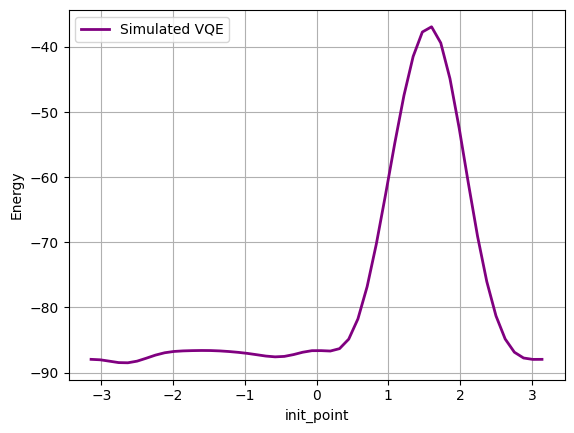

In [203]:
multiplier = init_point_finder(ansatz, optimizer_type, qubit_op)

In [204]:
multiplier 

-2.628679567289419

In [211]:
optimizer = get_optimizer(optimizer_type, max_iter =100 , a = 0.06, c = 0.06)

estimator = Estimator(
        options = {
            "method": "density_matrix",
            "coupling_map": coupling_map,
            "seed": seed, 
            "seed_transpiler": seed,
            "optimization_level":0,
        }
    )

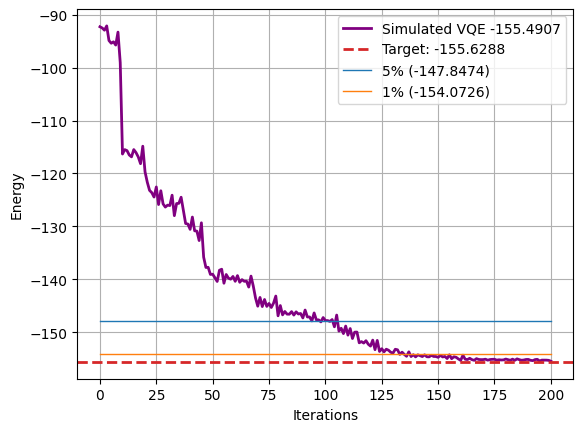

In [212]:
result, values = custom_vqe(estimator, 
                            ansatz_opt, 
                            optimizer, 
                            new_qubit_op,  
                            exact_energy,
                            execution_type,
                            multiplier)

In [213]:
print(result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 200,
    'eigenvalue': -155.4906904570573,
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f97b7b07760>,
    'optimal_parameters': {   ParameterVectorElement(θ[10]): -1.5826424996991306,
                              ParameterVectorElement(θ[2]): -2.163638413899733,
                              ParameterVectorElement(θ[0]): -3.1281196155573556,
                              ParameterVectorElement(θ[1]): -0.08077287802386753,
                              ParameterVectorElement(θ[3]): -1.5509007266936707,
                              ParameterVectorElement(θ[5]): -1.6285178767191881,
                              ParameterVectorElement(θ[4]): -1.6055662395648074,
                              ParameterVectorElement(θ[6]): -3.2053809926793293,
                              ParameterVectorElement(θ[8]): -1.0259233700640458,
                              ParameterVectorElement(θ[9]): -1.5654

In [214]:
# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(exact_energy, result.eigenvalue)

print(f'Expected ground state energy: {exact_energy:.12f}')
print(f'Computed ground state energy: {result.eigenvalue:.12f}')
print(f'Relative error: {rel_error:.12f}')

Expected ground state energy: -155.628847646236
Computed ground state energy: -155.490690457057
Relative error: 0.000887735091


In [215]:
interpreted_result = problem_reduced.interpret(result)
print(interpreted_result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -432.552017821301
  - computed part:      -155.490690457057
  - ActiveSpaceTransformer extracted energy part: -277.061327364244
~ Nuclear repulsion energy (Hartree): 154.047087551131
> Total ground state energy (Hartree): -278.50493027017
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [133.01202675  189.14873493  86.33957092]
 


In [216]:
total_energy = interpreted_result.total_energies[0]
print(f'Actual total energy: {actual_energy:.12f} Ha\n')
print(f"Total energy: {total_energy:.12f} Ha")
print(f"Total energy in ev: {total_energy*ev:.12f} ev\n")

rel_error = rel_err(actual_energy, total_energy*ev)
print(f'Relative error: {rel_error:.12f}')

Actual total energy: -7592.793905933788 Ha

Total energy: -278.504930270170 Ha
Total energy in ev: -7578.509059553706 ev

Relative error: 0.001881368908


## Results

The algorithm successufully converges to the computed part energy in ~25 seconds with a relative error within $10^{-3}$ Hartree.

The relative error of `VQE's ground state energy` with the `classical reference solution` is within $10^{-2}$ Hartree.

## Deparameterisation

We perfrom deparameterisation of the ansatz. Observe that most the parameters are approaching to standard values ($0, \pm \pi/2 \pm \pi$). We freeze these parameters and now we are left with only 5 parameters to optimize for. The optimization needed on 50 iterations (~ 13 seconds, a `48 percent decrease` in the runtime) with a relative errror within $10^{-4}$ Hartree.

The relative error of `VQE's ground state energy` with the `classical reference solution` is within $10^{-2}$ Hartree.

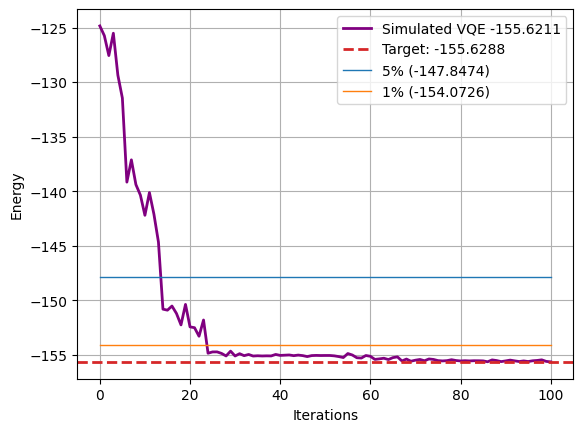

In [218]:
optimizer = get_optimizer(optimizer_type, max_iter = 50 , a = 0.06, c = 0.06)

tqc = deparameterise(result.optimal_circuit,
                     result.optimal_parameters,
                     [0,6], -np.pi)

tqc = deparameterise(result.optimal_circuit,
                     result.optimal_parameters,
                     [1], 0.0)

tqc = deparameterise(tqc,
                     result.optimal_parameters,
                     [3,4,5,9,10,11], -np.pi/2)

l1_result, values = custom_vqe(estimator, 
                                tqc, 
                                optimizer, 
                                new_qubit_op,  
                                exact_energy,
                                execution_type,
                                multiplier)

In [219]:
print(l1_result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 100,
    'eigenvalue': -155.62110677864038,
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f97b76aedf0>,
    'optimal_parameters': {   ParameterVectorElement(θ[2]): 0.262434085713471,
                              ParameterVectorElement(θ[0]): -3.1381885352151686,
                              ParameterVectorElement(θ[6]): -3.143504476161188,
                              ParameterVectorElement(θ[8]): -3.4042194927103155,
                              ParameterVectorElement(θ[7]): -3.175150390184614},
    'optimal_point': array([-3.13818854,  0.26243409, -3.14350448, -3.17515039, -3.40421949]),
    'optimal_value': -155.62110677864038,
    'optimizer_evals': None,
    'optimizer_result': <qiskit.algorithms.optimizers.optimizer.OptimizerResult object at 0x7f97b7387b80>,
    'optimizer_time': 13.085495233535767}


In [220]:
# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(exact_energy, l1_result.eigenvalue)

print(f'Expected ground state energy: {exact_energy:.12f}')
print(f'Computed ground state energy: {result.eigenvalue:.12f}')
print(f'Relative error: {rel_error:.12f}')

Expected ground state energy: -155.628847646236
Computed ground state energy: -155.490690457057
Relative error: 0.000049739285


In [221]:
interpreted_result = problem_reduced.interpret(l1_result)

total_energy = interpreted_result.total_energies[0]
print(f'Actual total energy: {actual_energy:.12f} Ha\n')
print(f"Total energy: {total_energy:.12f} Ha")
print(f"Total energy in ev: {total_energy*ev:.12f} ev\n")

rel_error = rel_err(actual_energy, total_energy*ev)
print(f'Relative error: {rel_error:.12f}')

Actual total energy: -7592.793905933788 Ha

Total energy: -278.635346591753 Ha
Total energy in ev: -7582.057870246832 ev

Relative error: 0.001413976966


## Noisy sim

We use Fake nairobi for noisy simulation provided by Qiskit. The noisy simulator consists of 7 qubits. We test the reduced parameter circuit with the noisy sim as backend. We try different error mitigation schemes which is controlled by the parameter `resilience level`.

Later we save the hamiltonian for using it with real hardware.

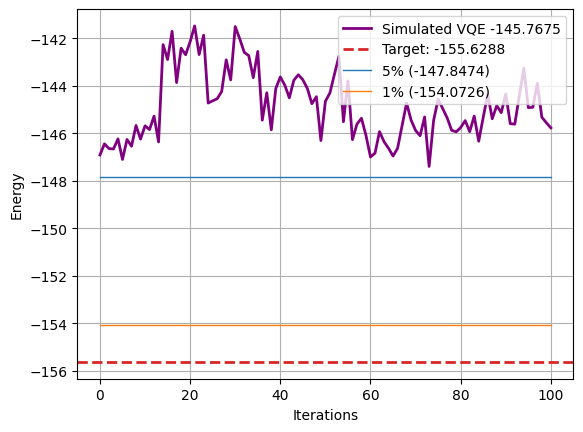

In [235]:
ansatz_opt = l1_result.optimal_circuit
initial_point = l1_result.optimal_point

noisy_sim_results = []
optimizer = get_optimizer(optimizer_type, max_iter = 50 , a = 0.02, c = 0.02)

for resilience_level in range(4):
    noisy_estimator = BackendEstimator(backend = noisy_sim, options = {
        'resilience_level': resilience_level,
        'shots': 1024,
    })

    result_noisy, values = custom_vqe(noisy_estimator, 
                                ansatz_opt, 
                                optimizer, 
                                new_qubit_op,  
                                exact_energy,
                                execution_type,
                                multiplier = None,
                                init_point = initial_point)

    noisy_sim_results.append(result_noisy)

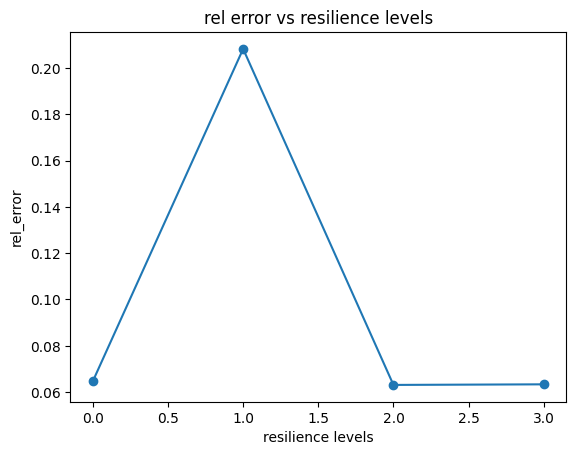

In [236]:
levels = list(range(len(noisy_sim_results)))
rel_errors = [rel_err(exact_energy, res.eigenvalue) for res in noisy_sim_results]
plt.plot(levels, rel_errors, marker='o')
plt.xlabel('resilience levels')
plt.ylabel('rel_error')
plt.title('rel error vs resilience levels');

In [237]:
interpreted_result = problem_reduced.interpret(noisy_sim_results[-1])

total_energy = interpreted_result.total_energies[0]
print(f'Actual total energy: {actual_energy:.12f} Ha\n')
print(f"Total energy: {total_energy:.12f} Ha")
print(f"Total energy in ev: {total_energy*ev:.12f} ev\n")

rel_error = rel_err(actual_energy, total_energy*ev)
print(f'Relative error: {rel_error:.12f}')

Actual total energy: -7592.793905933788 Ha

Total energy: -268.781718777483 Ha
Total energy in ev: -7313.926862341596 ev

Relative error: 0.036727856313


### Results with Noisy sim

The lowest relative error was achieved at `resilience level = 3` and the computed part energy is within 6.3 percent the actual computed part energy. There is a rise in the relative error with level=1 which is more than level=0 (no mitigation). The reason being that with no-mitigation, the result might have found a local minima by chance. We ran it few more times and verified it. We can perform further experiments on this topic on noise mitigation.

The relative error of `VQE's ground state energy` with the `classical reference solution` at `resilience level = 3` is within $10^{-1}$ Hartree (`3.6 percent`).

In [238]:
import pickle

H = {
    'coeffs': [],
    'ops': []
}

for op in qubit_op:
    pauli_string = op.primitive.paulis[0]
    pauli_string = pauli_string.__str__()

    pauli_coeff = op.primitive.coeffs[0]
    H['ops'].append(pauli_string)
    H['coeffs'].append(pauli_coeff)

with open('hamiltonian.pickle', 'wb') as handle:
    pickle.dump(H, handle, protocol=pickle.HIGHEST_PROTOCOL)

## What's next?

In the next notebook we take the VQE on the AWS SV1 Simulator for amine-co2 system. We use pennylane for this purpose and it has pennylane-braket-plugin.